## Evaluatin of OPE estimators

In [11]:
import time

import numpy as np
import pandas as pd
from pandas import DataFrame
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# import OFRL modules
import ofrl
from ofrl.dataset import (
    SyntheticBanditDataset,
)
from obp.policy import IPWLearner
from obp.ope import (
    OffPolicyEvaluation, 
    RegressionModel,
    InverseProbabilityWeighting as IPS,
    SelfNormalizedInverseProbabilityWeighting as SNIPS,
    DirectMethod as DM,
    DoublyRobust as DR,
    DoublyRobustWithShrinkage as DRos,
)
from obp.utils import softmax

In [12]:
print(obp.__version__)

0.4.1


In [13]:
## configurations
num_runs = 200
num_data_list = [100, 200, 400, 800, 1600, 3200, 6400, 12800, 25600, 51200]

In [14]:
## define a dataset class
dataset = SyntheticBanditDataset(
    n_actions=10, 
    dim_context=10,
    # tau=0.2, 
    reward_function=logistic_reward_function,
    behavior_policy_function=linear_behavior_policy,
    random_state=12345,
)
### training data is used to train an evaluation policy
train_bandit_data = dataset.obtain_batch_bandit_feedback(n_rounds=5000)
### test bandit data is used to approximate the ground-truth policy value
test_bandit_data = dataset.obtain_batch_bandit_feedback(n_rounds=100000)

In [15]:
## evaluation policy training
ipw_learner = IPWLearner(
    n_actions=dataset.n_actions,
    base_classifier=RandomForestClassifier(random_state=12345),
)
ipw_learner.fit(
    context=train_bandit_data["context"], 
    action=train_bandit_data["action"], 
    reward=train_bandit_data["reward"], 
    pscore=train_bandit_data["pscore"], 
)
action_dist_ipw_test = ipw_learner.predict(
    context=test_bandit_data["context"],
)
policy_value_of_ipw = dataset.calc_ground_truth_policy_value(
    expected_reward=test_bandit_data["expected_reward"], 
    action_dist=action_dist_ipw_test, 
)

In [16]:
## evaluation of OPE estimators
se_df_list = []
for num_data in num_data_list:
    se_list = []
    for _ in tqdm(range(num_runs), desc=f"num_data={num_data}..."):
        ## generate validation data
        validation_bandit_data = dataset.obtain_batch_bandit_feedback(
            n_rounds=num_data
        )

        ## make decisions on vlidation data
        action_dist_ipw_val = ipw_learner.predict(
            context=validation_bandit_data["context"],
        )

        ## OPE using validation data
        regression_model = RegressionModel(
            n_actions=dataset.n_actions, 
            base_model=LogisticRegression(C=100, max_iter=10000, random_state=12345),
        )
        estimated_rewards = regression_model.fit_predict(
            context=validation_bandit_data["context"], # context; x
            action=validation_bandit_data["action"], # action; a
            reward=validation_bandit_data["reward"], # reward; r
            n_folds=2, # 2-fold cross fitting
            random_state=12345,
        )
        ope = OffPolicyEvaluation(
            bandit_feedback=validation_bandit_data,
            ope_estimators=[
                IPS(estimator_name="IPS"), 
                DM(estimator_name="DM"), 
                IPS(estimator_name="CIPS"), 
                # IPS(lambda_=5, estimator_name="CIPS"), 
                SNIPS(estimator_name="SNIPS"),
                DR(estimator_name="DR"), 
                DRos(lambda_=500, estimator_name="DRos"), 
            ]
        )
        squared_errors = ope.evaluate_performance_of_estimators(
            ground_truth_policy_value=policy_value_of_ipw, # V(\pi_e)
            action_dist=action_dist_ipw_val, # \pi_e(a|x)
            estimated_rewards_by_reg_model=estimated_rewards, # \hat{q}(x,a)
            metric="se", # squared error
        )
        se_list.append(squared_errors)
    ## maximum importance weight in the validation data
    ### a larger value indicates that the logging and evaluation policies are greatly different
    max_iw = (action_dist_ipw_val[
        np.arange(validation_bandit_data["n_rounds"]), 
        validation_bandit_data["action"], 
        0
    ] / validation_bandit_data["pscore"]).max()
    tqdm.write(f"maximum importance weight={np.round(max_iw, 5)}\n")

    ## summarize results
    se_df = DataFrame(DataFrame(se_list).stack())\
        .reset_index(1).rename(columns={"level_1": "est", 0: "se"})
    se_df["num_data"] = num_data
    se_df_list.append(se_df)
    tqdm.write("=====" * 15)
    time.sleep(0.5)

# aggregate all results 
result_df = pd.concat(se_df_list).reset_index(level=0)

num_data=100...: 100%|██████████| 200/200 [00:02<00:00, 72.58it/s]


maximum importance weight=10.08863



num_data=200...: 100%|██████████| 200/200 [00:02<00:00, 70.95it/s]


maximum importance weight=17.48556



num_data=400...: 100%|██████████| 200/200 [00:03<00:00, 56.69it/s]


maximum importance weight=10.08863



num_data=800...: 100%|██████████| 200/200 [00:05<00:00, 39.30it/s]


maximum importance weight=17.48556



num_data=1600...: 100%|██████████| 200/200 [00:24<00:00,  8.18it/s]


maximum importance weight=19.287



num_data=3200...: 100%|██████████| 200/200 [00:43<00:00,  4.55it/s]


maximum importance weight=19.287



num_data=6400...: 100%|██████████| 200/200 [01:03<00:00,  3.17it/s]


maximum importance weight=19.287



num_data=12800...: 100%|██████████| 200/200 [01:45<00:00,  1.89it/s]


maximum importance weight=19.287



num_data=25600...: 100%|██████████| 200/200 [02:59<00:00,  1.11it/s]


maximum importance weight=19.287



num_data=51200...: 100%|██████████| 200/200 [05:05<00:00,  1.53s/it]


maximum importance weight=19.287



## Visualize Results

In [ ]:
# figure configs
query = "(est == 'DM' or est == 'IPS') and num_data <= 6400"
xlabels = [100, 400, 1600, 6400]

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 7), tight_layout=True)
sns.lineplot(
    linewidth=5,
    dashes=False,
    legend=False,
    x="num_data",
    y="se",
    hue="est",
    ax=ax,
    data=result_df.query("(est == 'DM' or est == 'IPS') and num_data <= 12800"),
)
# title and legend
ax.legend(["IPS", "DM"], loc="upper right", fontsize=25)
# yaxis
ax.set_yscale("log")
ax.set_ylabel("mean squared error (MSE)", fontsize=25)
ax.tick_params(axis="y", labelsize=15)
ax.yaxis.set_label_coords(-0.08, 0.5)
# xaxis
ax.set_xscale("log")
ax.set_xlabel("number of samples in the log data", fontsize=25)
ax.set_xticks(xlabels)
ax.set_xticklabels(xlabels, fontsize=15)
ax.xaxis.set_label_coords(0.5, -0.1)

In [23]:
plt.show()

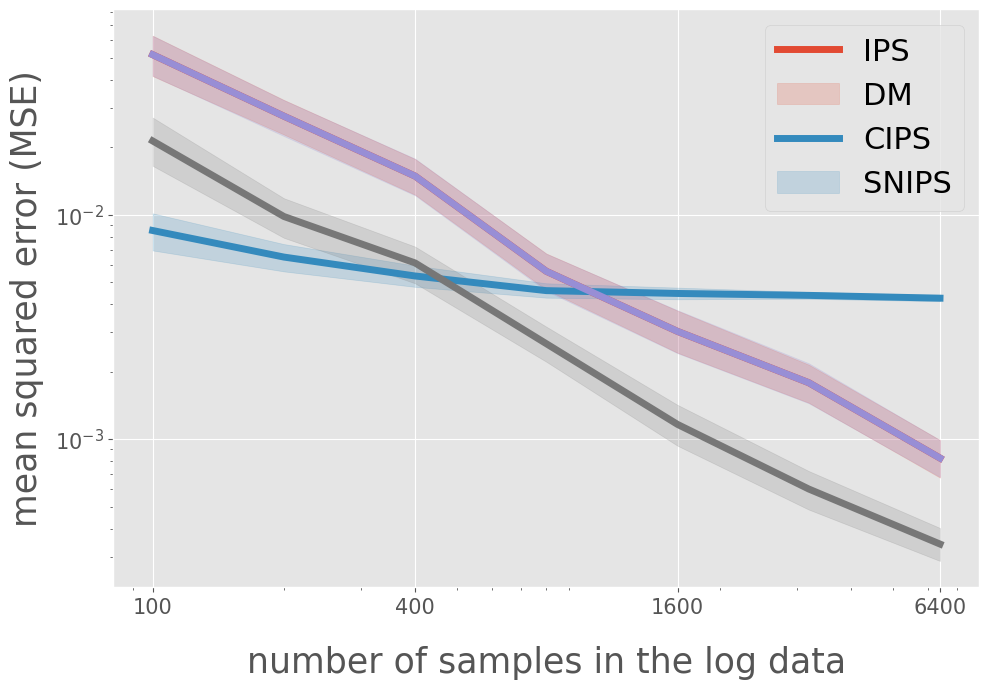

In [18]:
# figure configs
query = "(est == 'DM' or est == 'CIPS' or est == 'IPS' or est == 'SNIPS')" 
query += "and num_data <= 6400"
xlabels = [100, 400, 1600, 6400]

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 7), tight_layout=True)
sns.lineplot(
    linewidth=5,
    dashes=False,
    legend=False,
    x="num_data",
    y="se",
    hue="est",
    ax=ax,
    data=result_df.query(query),
)
# title and legend
ax.legend(["IPS", "DM", "CIPS", "SNIPS"], loc="upper right", fontsize=22)
# yaxis
ax.set_yscale("log")
ax.set_ylabel("mean squared error (MSE)", fontsize=25)
ax.tick_params(axis="y", labelsize=15)
ax.yaxis.set_label_coords(-0.08, 0.5)
# xaxis
ax.set_xscale("log")
ax.set_xlabel("number of samples in the log data", fontsize=25)
ax.set_xticks(xlabels)
ax.set_xticklabels(xlabels, fontsize=15)
ax.xaxis.set_label_coords(0.5, -0.1)

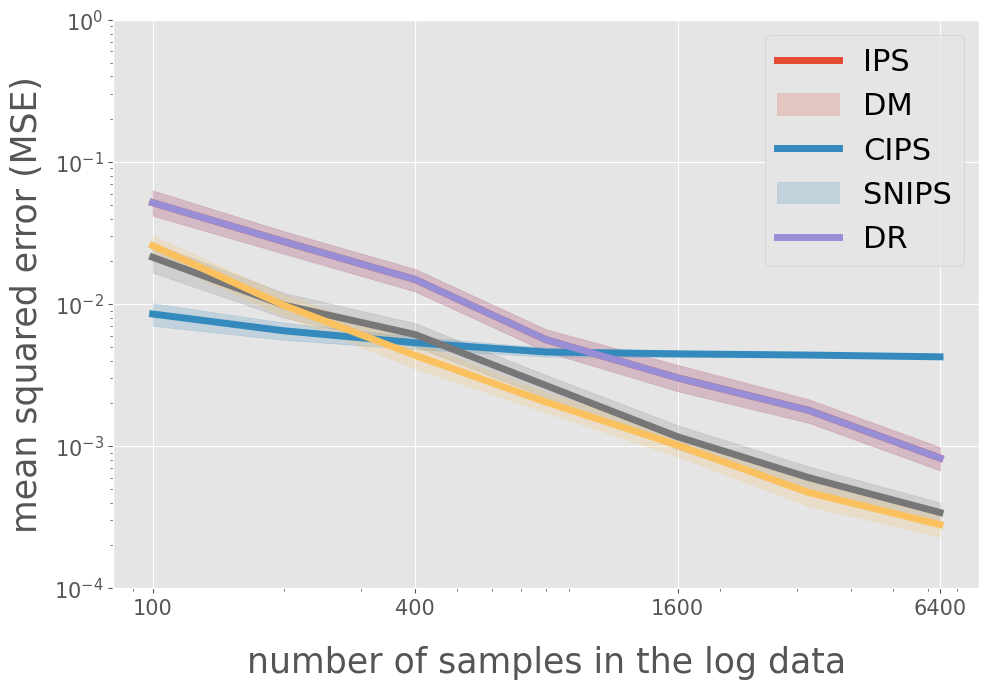

In [19]:
# figure configs
query = "(est == 'DM' or est == 'IPS' or est == 'SNIPS' or est == 'CIPS' or est == 'DR')"
query += "and num_data <= 6400"
xlabels = [100, 400, 1600, 6400]

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 7), tight_layout=True)
sns.lineplot(
    linewidth=5,
    dashes=False,
    legend=False,
    x="num_data",
    y="se",
    hue="est",
    ax=ax,
    data=result_df.query(query),
)
# title and legend
ax.legend(["IPS", "DM", "CIPS", "SNIPS", "DR"], loc="upper right", fontsize=22)
# yaxis
ax.set_yscale("log")
ax.set_ylim(1e-4, 1)
ax.set_ylabel("mean squared error (MSE)", fontsize=25)
ax.tick_params(axis="y", labelsize=15)
ax.yaxis.set_label_coords(-0.08, 0.5)
# xaxis
ax.set_xscale("log")
ax.set_xlabel("number of samples in the log data", fontsize=25)
ax.set_xticks(xlabels)
ax.set_xticklabels(xlabels, fontsize=15)
ax.xaxis.set_label_coords(0.5, -0.1)

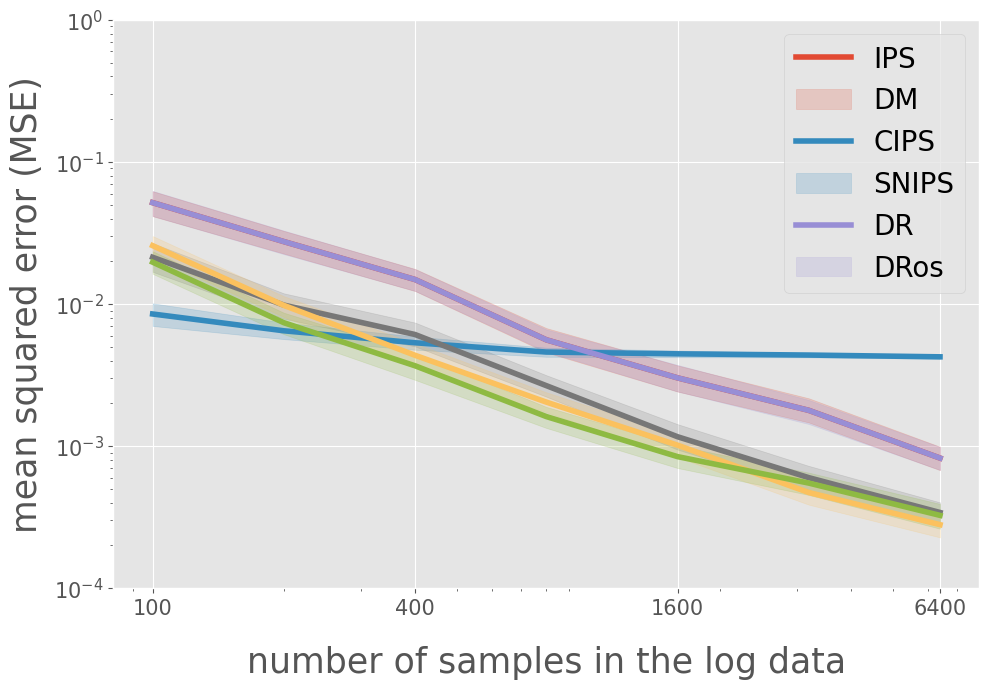

In [20]:
# figure configs
query = "num_data <= 6400"
xlabels = [100, 400, 1600, 6400]

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 7), tight_layout=True)
sns.lineplot(
    linewidth=4,
    dashes=False,
    legend=False,
    x="num_data",
    y="se",
    hue="est",
    ax=ax,
    data=result_df.query(query),
)
# title and legend
ax.legend(["IPS", "DM", "CIPS", "SNIPS", "DR", "DRos"], loc="upper right", fontsize=20)
# yaxis
ax.set_yscale("log")
ax.set_ylim(1e-4, 1)
ax.set_ylabel("mean squared error (MSE)", fontsize=25)
ax.tick_params(axis="y", labelsize=15)
ax.yaxis.set_label_coords(-0.08, 0.5)
# xaxis
ax.set_xscale("log")
ax.set_xlabel("number of samples in the log data", fontsize=25)
ax.set_xticks(xlabels)
ax.set_xticklabels(xlabels, fontsize=15)
ax.xaxis.set_label_coords(0.5, -0.1)

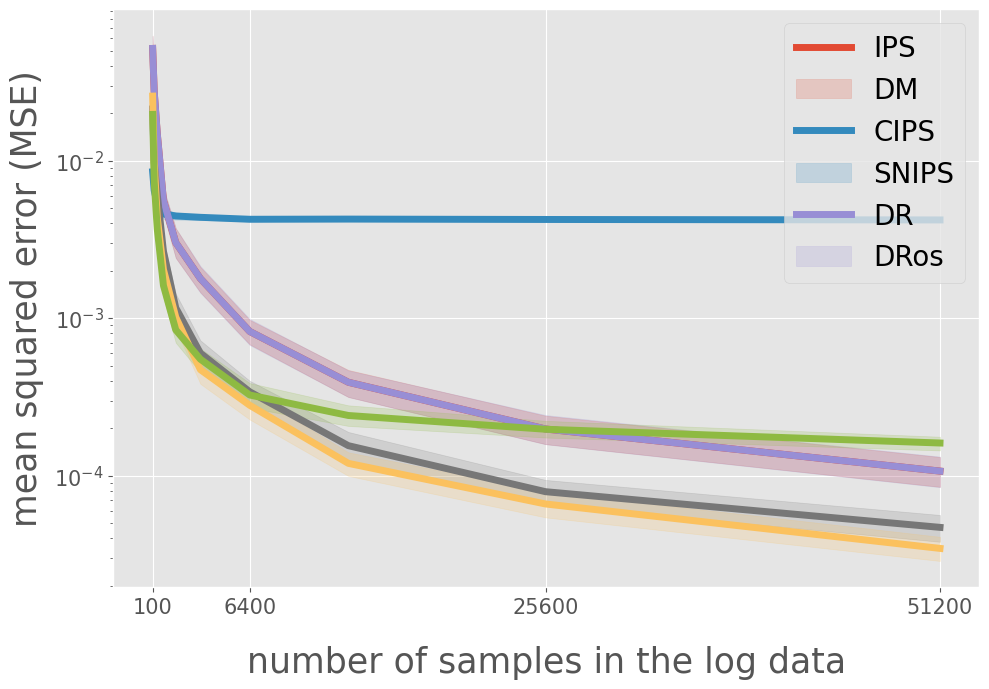

In [21]:
xlabels = [100, 6400, 25600, 51200]

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 7), tight_layout=True)
sns.lineplot(
    linewidth=5,
    dashes=False,
    legend=False,
    x="num_data",
    y="se",
    hue="est",
    ax=ax,
    data=result_df,
)
# title and legend
ax.legend(["IPS", "DM", "CIPS", "SNIPS", "DR", "DRos"], loc="upper right", fontsize=20)
# yaxis
ax.set_yscale("log")
ax.set_ylabel("mean squared error (MSE)", fontsize=25)
ax.tick_params(axis="y", labelsize=15)
ax.yaxis.set_label_coords(-0.08, 0.5)
# xaxis
ax.set_xlabel("number of samples in the log data", fontsize=25)
ax.set_xticks(xlabels)
ax.set_xticklabels(xlabels, fontsize=15)
ax.xaxis.set_label_coords(0.5, -0.1)